# Extreme multi-class classification

ID2223 Scalable Machine Learning and Deep Learning

**Federico Baldassarre (fedbal@kth.se) and Beatrice Ionascu (bionascu@kth.se)**

In [27]:
# render our plots inline
%matplotlib inline
# always reload modules marked with "%aimport"
%load_ext autoreload

import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from utils.paths import data_raw_dir
from utils.paths import data_processed_dir


#pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem

## Data set

In [2]:
#TODO there are 7 million products (not images!) --> there's > 7 million images

The cdiscount dataset consists of 15 million images at 180x180 resolution of almost 9
million products from France’s largest non-food e-commerce company.
The training data consists of a list of 7,069,896 dictionaries, one per product.
Each dictionary contains a product id, the category id of the product, and between
1-4 images, stored in a list. In addition, each category id has a corresponding level1,
level2, and level3 name, in French.

In [22]:
print(cat_id_distrib.sum(), 'products')

7069896 products


In [ ]:
# TODO count images

In [3]:
categ_counts = pd.read_csv(os.path.join(data_raw_dir, 'category_names.csv'))
print(categ_counts.nunique().to_frame('Category counts'))

                 Category counts
category_id                 5270
category_level1               49
category_level2              483
category_level3             5263


The 5270 available categories are very unevenly distributed amongst the products. The distribution of the number of products per `category_id` approximately follows a power law, with a long tail of categories containing a large number of products. Similar trends are observed for the distribution of the level 1, 2 and 3 categories amongst the products as well.

In [26]:
categories = pd.read_pickle(os.path.join(data_processed_dir, 'categories.pickle'))
display(HTML(categories.filter(like='category', axis=1).head().to_html(index=False)))

category_id,category_level1,category_level2,category_level3
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR


Text(0.5,1,'Category id (5270)')

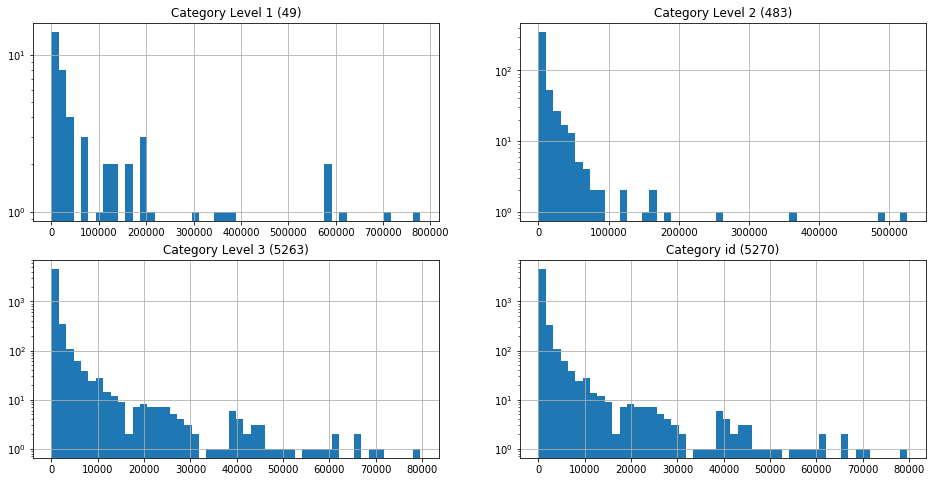

In [39]:
cat_id_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_id_counts.pickle'))
cat_1_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_1_counts.pickle'))
cat_2_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_2_counts.pickle'))
cat_3_distrib = pd.read_pickle(os.path.join(data_processed_dir, 'cat_3_counts.pickle'))
fig, ax = plt.subplots(2, 2, figsize=(16,8))
ax=ax.ravel()

cat_1_distrib.hist(log=True, bins=50,ax=ax[0])
ax[0].set_title('Category Level 1 ({})'.format(cat_1_distrib.size))
cat_2_distrib.hist(log=True, bins=50,ax=ax[1])
ax[1].set_title('Category Level 2 ({})'.format(cat_2_distrib.size))
cat_3_distrib.hist(log=True, bins=50,ax=ax[2])
ax[2].set_title('Category Level 3 ({})'.format(cat_3_distrib.size))
cat_id_distrib.hist(log=True, bins=50,ax=ax[3])
ax[3].set_title('Category id ({})'.format(cat_id_distrib.size))

In [57]:
pd.merge(categories.filter(like='category'), 
         cat_id_distrib.sort_values(ascending=False).iloc[np.r_[0:5, -5:0]].to_frame('counts'),
         left_index=True, right_index=True).sort_values('counts', ascending=False)

,category_id,category_level1,category_level2,category_level3,counts
4576,1000018296,MUSIQUE,CD,CD POP ROCK - CD ROCK INDE,79640
2489,1000011423,INFORMATIQUE,IMPRESSION - SCANNER,TONER - RECUPERATEUR DE TONER,71116
2490,1000011427,INFORMATIQUE,IMPRESSION - SCANNER,CARTOUCHE IMPRIMANTE,69784
3245,1000014202,LIBRAIRIE,LITTERATURE,LITTERATURE FRANCAISE,65642
3611,1000015309,LIBRAIRIE,AUTRES LIVRES,AUTRES LIVRES,65435
3706,1000015609,CHAUSSURES - ACCESSOIRES,ACCESSOIRES CHAUSSURES,ESSUIE-BOTTES - LAVE-BOTTES,12
3016,1000013297,ELECTRONIQUE,CAPTEURS,SYSTEME DE SURVEILLANCE DE NIVEAU,12
2023,1000008894,JEUX - JOUETS,JONGLERIE,ASSIETTE CHINOISE,12
5034,1000019804,SPORT,BASEBALL,BLOUSON DE BASEBALL - VESTE DE BASEBALL,12
5171,1000020847,TV - VIDEO - SON,PROTECTION - ENTRETIEN,HOUSSE POUR ENREGISTEUR - HOUSSE POUR DICTAPHO...,12


## Approach
Use xceptio as feature extraction
Architecture: Learn a few conv layer and a softmax dense
compare negative sampling with regular cross entropy loss

## Pre-processing
### Label encoding

## Feature Extraction
### TfRecords



### Computation graph
![computation graph](../figures/computational_graph.png)

## Training

We trained the network using two different loss functions.

explain epoch / step/batch size


## Results

TODO: legend, x axis label
collage?

![](../figures/test_acc.png)
![](../figures/test_loss.png)
![](../figures/train_acc.png)
![](../figures/train_loss.png)

- classification accuracy and loss per image
- can't test on the test data since we don't have access to it ...



#### Future work
- group images into products -- report results per product
- use heirarchy
- use OCR for books
- ...